# Plots for CPVT Patients on Beta Blockers

Also exports the tables into a csv for R to parse for Fisher's Exact Test in step 10

In [1]:
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

from analysis.database import get_config, get_engine, set_figure_size, \
    FigureParams

In [2]:

sns.set_style("ticks")

In [3]:
config = get_config()

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir, "analysis_09"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

In [4]:
def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir / f"{name}.{fmt}"), dpi=300)

In [5]:
df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_cpvt = df[
    df["Catecholaminergic polymorphic ventricular tachycardia 1"] == 1
    ]
df_cpvt_bb = df_cpvt[
    df_cpvt["treatment_taken::Beta blocker"] == 1
    ].copy()

## Treatment Records (ANY)
 Num cpvt patients on any treatment

In [7]:
treatment_cols: list[str] = [
    col for col in df_cpvt.columns if col.startswith("treatment_taken::")
]
treatment_cols

['treatment_taken::Beta blocker',
 'treatment_taken::Catheter ablation',
 'treatment_taken::Enalapril',
 'treatment_taken::Flecainide',
 'treatment_taken::Implantable cardioverter-defibrillator',
 'treatment_taken::Left cardiac sympathetic denervation',
 'treatment_taken::Verapamil']

In [8]:
patient_ids = set()

for col in treatment_cols:
    # Include all patients who have a record of treatment or not treatment
    df_treat = df_cpvt[df_cpvt[col].notna()]
    patient_ids.update(df_treat["individual_id"])

print(f"There are {len(patient_ids)} CPVT patients with a treatment recorded")

There are 601 CPVT patients with a treatment recorded


In [9]:
# with get_engine() as engine:
#     num_patients = pd.read_sql("""
#     SELECT COUNT(DISTINCT patient_id) AS num_patients
#     FROM treatment_record tr
#     JOIN treatment t
#     ON tr.treatment_id = t.treatment_id
#     WHERE tr.patient_id IN (
#         SELECT individual_id
#         FROM cpvt_patients_v
#     ) AND
#     tr.treatment_taken IS NOT NULL
#     """, engine)

# num_patients

In [10]:
print(
    f"Of the {len(patient_ids)} patients with any treatment record, "
    f"{len(df_cpvt_bb)} ({len(df_cpvt_bb) / len(patient_ids) * 100:.2f}%) "
    f"are on beta blockers")

Of the 601 patients with any treatment record, 432 (71.88%) are on beta blockers


## Beta Blocker + Pharmacological Treatment

In [11]:
pharm_treat = [
    # 'treatment_taken::Enalapril',
    'treatment_taken::Flecainide',
    'treatment_taken::Verapamil'
]

patients_pharm_bb = set()
for col in pharm_treat:
    df_bb_and_pharm = df_cpvt_bb[df_cpvt_bb[col] == 1]
    patients_pharm_bb.update(df_bb_and_pharm["individual_id"])

len(patients_pharm_bb)

129

In [12]:
invasive_treat = [
    'treatment_taken::Catheter ablation',
    'treatment_taken::Implantable cardioverter-defibrillator',
    'treatment_taken::Left cardiac sympathetic denervation',
]

patients_invasive_bb = set()
for col in invasive_treat:
    df_bb_and_invasive = df_cpvt_bb[df_cpvt_bb[col] == 1]
    patients_invasive_bb.update(df_bb_and_invasive["individual_id"])

len(patients_invasive_bb)

129

## Upset Plot

In [13]:
from upsetplot import UpSet, from_indicators

df_upset = df_cpvt_bb[
    ['treatment_taken::Beta blocker'] + pharm_treat + invasive_treat + [
        "individual_id"]
    ].drop_duplicates("individual_id", keep="first").drop(
    columns="individual_id"
).fillna(0).astype(bool)

column_map = {
    'treatment_taken::Beta blocker': 'Beta blocker',
    # 'treatment_taken::Enalapril': 'Enalapril',
    'treatment_taken::Flecainide': 'Flecainide',
    'treatment_taken::Verapamil': 'Verapamil',
    'treatment_taken::Catheter ablation': 'Catheter ablation',
    'treatment_taken::Implantable cardioverter-defibrillator': 'ICD',
    'treatment_taken::Left cardiac sympathetic denervation': 'LCSD',
}

df_upset = df_upset.rename(
    columns=column_map
).reset_index().drop(columns="index")

# df_upset["Beta blocker only"] = ~(
#         df_upset["Enalapril"] | df_upset["Flecainide"] | df_upset["Verapamil"] |
#         df_upset["Catheter ablation"] | df_upset["ICD"] | df_upset["LCSD"]
# )
# df_upset = df_upset[
#     ["Beta blocker only"] + [
#         column_map[col] for col in pharm_treat + invasive_treat
#     ]
#     ]

df_upset.head()

,Beta blocker,Flecainide,Verapamil,Catheter ablation,ICD,LCSD
0,True,True,False,False,False,False
1,True,False,False,False,False,False
2,True,True,False,False,True,True
3,True,False,False,False,False,False
4,True,False,False,False,False,False


In [14]:
from_indicators(
    df_upset.columns, data=df_upset
)

Beta blocker  \
Beta blocker Flecainide Verapamil Catheter ablation ICD   LCSD                  
True         True       False     False             False False          True   
             False      False     False             False False          True   
             True       False     False             True  True           True   
             False      False     False             False False          True   
                                                          False          True   
...                                                                       ...   
                                                          False          True   
             True       False     False             False False          True   
             False      False     False             False False          True   
             True       False     False             True  True           True   
             False      False     False             False False          True   

                                                                 Flecainide  \
Beta blocker Flecainide Verapamil Catheter ablation ICD   LCSD                
True         True       False     False             False False        True   
             False      False     False             False False       False   
             True       False     False             True  True         True   
             False      False     False             False False       False   
                                                          False       False   
...                                                                     ...   
                                                          False       False   
             True       False     False             False False        True   
             False      False     False             False False       False   
             True       False     False             True  True         True   
             False      False     False             False False       False   

                                                                 Verapamil  \
Beta blocker Flecainide Verapamil Catheter ablation ICD   LCSD               
True         True       False     False             False False      False   
             False      False     False             False False      False   
             True       False     False             True  True       False   
             False      False     False             False False      False   
                                                          False      False   
...                                                                    ...   
                                                          False      False   
             True       False     False             False False      False   
             False      False     False             False False      False   
             True       False     False             True  True       False   
             False      False     False             False False      False   

                                                                 Catheter ablation  \
Beta blocker Flecainide Verapamil Catheter ablation ICD   LCSD                       
True         True       False     False             False False              False   
             False      False     False             False False              False   
             True       False     False             True  True               False   
             False      False     False             False False              False   
                                                          False              False   
...                                                                            ...   
                                                          False              False   
             True       False     False             False False              False   
             False      False     False             False False              False   
             True     

/Users/ac4294/.pyenv/versions/anaconda3-2024.10-1/envs/cpvt_database_analysis/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/ac4294/.pyenv/versions/anaconda3-2024.10-1/envs/cpvt_database_analysis/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This

<Figure size 650x300 with 0 Axes>

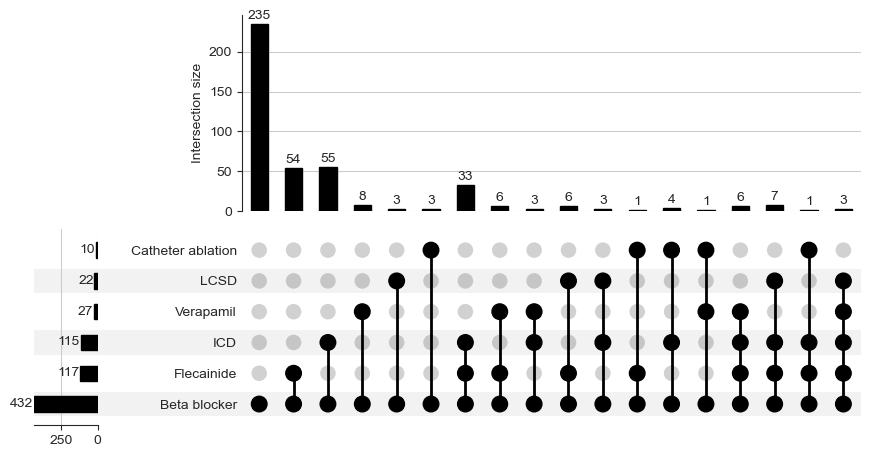

In [15]:
plt.figure(figsize=(6.5, 3))
upsetplot = UpSet(
    from_indicators(
        df_upset.columns, data=df_upset
    ),
    show_counts=True,
    # max_degree=3
)

upsetplot.plot()
plt.tight_layout()

save_current_plot("upset_plot")

## Beta Blocker + Any other

In [16]:
# get number of patients on each treatment
treatments = {
    "Beta blocker": "BB\nonly",
    "Catheter ablation": "Catheter\nablation\n& BB",
    # "Enalapril": "Enalapril\n& BB",
    "Flecainide": "Flecainide\n& BB",
    "Implantable cardioverter-defibrillator": "ICD\n& BB",
    "Left cardiac sympathetic denervation": "LCSD\n& BB",
    "Verapamil": "Verapamil\n& BB",
}

treatment_nums = []

taken_other_treatments = set()

for treatment, plt_name in treatments.items():

    if treatment == "Beta blocker":
        continue

    extra_treatment = df_cpvt_bb[
        df_cpvt_bb[f"treatment_taken::{treatment}"] == 1
        ]["individual_id"]

    num_patients_treatments = len(set(
        extra_treatment
    ))
    taken_other_treatments.update(extra_treatment)

    treatment_nums.append({
        "treatment": plt_name,
        "num_patients": num_patients_treatments
    })

bb_only = len(set(df_cpvt_bb["individual_id"]) - taken_other_treatments)
treatment_nums.append({
    "treatment": treatments["Beta blocker"],
    "num_patients": bb_only
})

treatment_nums = pd.DataFrame(treatment_nums)
treatment_nums = treatment_nums.sort_values(by="num_patients", ascending=False)

treatment_nums

,treatment,num_patients
5,BB\nonly,235
1,Flecainide\n& BB,117
2,ICD\n& BB,115
4,Verapamil\n& BB,27
3,LCSD\n& BB,22
0,Catheter\nablation\n& BB,10


<Axes: xlabel='treatment', ylabel='num_patients'>

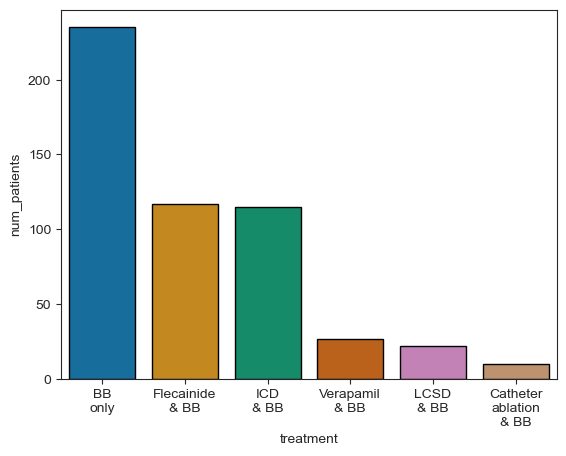

In [17]:
sns.barplot(
    data=treatment_nums,
    y="num_patients",
    x="treatment",
    palette=sns.color_palette(get_config().figure_palette.cat_palette,
                              len(treatments)),
    edgecolor="black",
    hue="treatment",
    legend=False
)

## Plotting

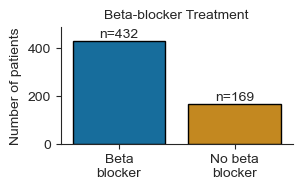

In [18]:
from matplotlib.gridspec import SubplotSpec


def plot_counts_df(
        patients_group_a: int,
        patients_group_b: int,
        *,
        group_a: str,
        group_b: str,
        panel: FigureParams,
        plt_figure: plt.Figure | None = None,
        subplot_spec: SubplotSpec | None = None,
        fig_name: str | None = None,
        show: bool = False
):
    df_counted = pd.DataFrame(
        [
            {
                "group": group_a,
                "num_patients": patients_group_a
            },
            {
                "group": group_b,
                "num_patients": patients_group_b
            }
        ],
    )

    if plt_figure is None:
        _, ax = plt.subplots(figsize=panel.fig_size)
    else:
        ax = plt_figure.add_subplot(subplot_spec)

    sns.barplot(
        data=df_counted,
        x="group",
        y="num_patients",
        palette=sns.color_palette(get_config().figure_palette.cat_palette, 2),
        edgecolor="black",
        hue="group",
        hue_order=[group_a, group_b],
        legend=False,
        ax=ax
    )

    add_bar_label(ax, panel)
    set_figure_size(
        panel
    )

    if fig_name:
        save_current_plot(fig_name)

    if show:
        plt.show()


def add_bar_label(curr_ax: plt.Axes, panel: FigureParams,
                  *, front_space: int = 0, adj_y: bool = True):
    spaces = " " * front_space if front_space else ""

    for container_ in curr_ax.containers:
        curr_ax.bar_label(
            container_,
            # fmt="n=%g",
            fmt=f"{spaces}n=%g",
            fontsize=panel.text_fontsize,
        )

    # adjust y axis
    if adj_y:
        y_min, y_max = curr_ax.get_ylim()
        curr_ax.set_ylim(y_min, (y_max - y_min) * 0.075 + y_max)


plot_counts_df(
    len(set(df_cpvt_bb["individual_id"])),
    len(
        patient_ids - set(df_cpvt_bb["individual_id"])
    ),
    group_a="Beta\nblocker",
    group_b="No beta\nblocker",
    panel=get_config().s_figure_treatments.panels["bb_vs_non_bb"],
    fig_name="bb_vs_non_bb"
)

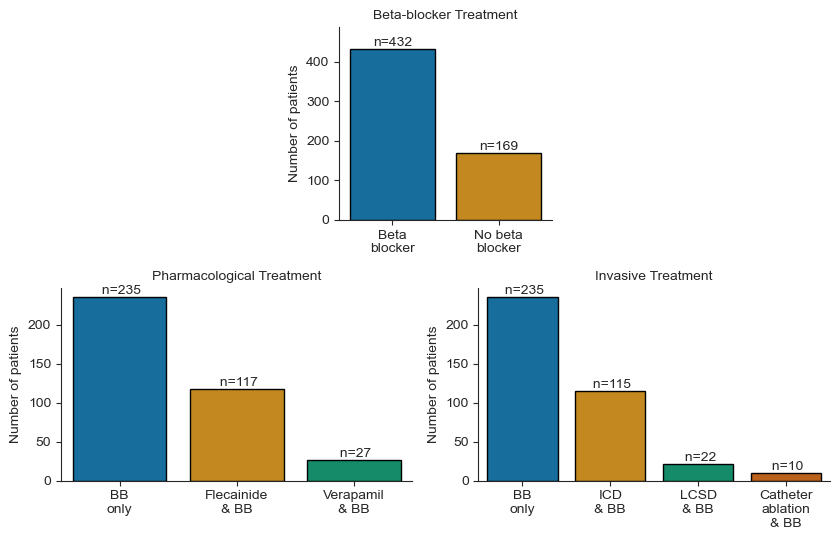

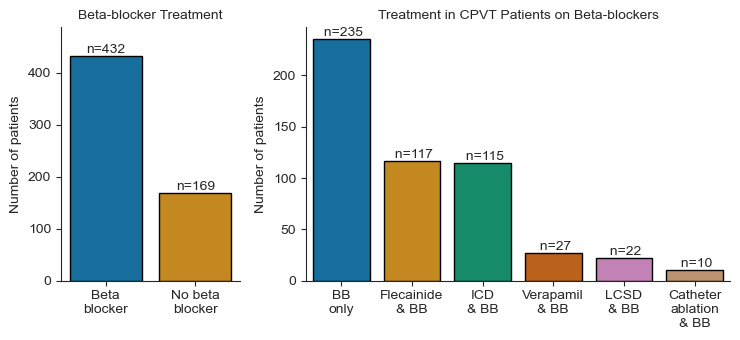

In [19]:
from matplotlib.gridspec import GridSpec


# Pharm
def plot_treatment_counts(
        df_: pd.DataFrame,
        treatments_plt: list[str],
        *,
        panel: FigureParams,
        plt_figure: plt.Figure,
        subplot_spec: SubplotSpec,

):
    plt_names = [v for k, v in treatments.items() if k in treatments_plt]

    df_select = df_[
        df_["treatment"].isin(plt_names)
    ]

    ax = plt_figure.add_subplot(subplot_spec)

    sns.barplot(
        data=df_select,
        y="num_patients",
        x="treatment",
        palette=sns.color_palette(get_config().figure_palette.cat_palette,
                                  len(plt_names)),
        edgecolor="black",
        hue="treatment",
        # hue_order=plt_names,
        legend=False,
        # orient="h",
        ax=ax
    )

    add_bar_label(ax, panel, front_space=1, adj_y=False)

    set_figure_size(
        panel,
    )


def plot_treatments():
    fig = plt.figure(figsize=get_config().s_figure_treatments.fig_size)
    n_col = 6
    n_row = 2
    gs = GridSpec(n_row, n_col, figure=fig)

    plot_counts_df(
        len(set(df_cpvt_bb["individual_id"])),
        len(
            patient_ids - set(df_cpvt_bb["individual_id"])
        ),
        group_a="Beta\nblocker",
        group_b="No beta\nblocker",
        panel=get_config().s_figure_treatments.panels["bb_vs_non_bb"],
        plt_figure=fig,
        subplot_spec=gs[0, 2:4]
    )
    plot_treatment_counts(
        treatment_nums,
        ["Beta blocker",
         # "Enalapril",
         "Flecainide",
         "Verapamil"],
        panel=get_config().s_figure_treatments.panels[
            "pharmacological_treatment"],
        plt_figure=fig,
        subplot_spec=gs[1, :3]
    )

    plot_treatment_counts(
        treatment_nums,
        ["Beta blocker", "Catheter ablation",
         "Implantable cardioverter-defibrillator",
         "Left cardiac sympathetic denervation"],
        panel=get_config().s_figure_treatments.panels["invasive_treatment"],
        plt_figure=fig,
        subplot_spec=gs[1, 3:]
    )
    fig.tight_layout()
    # plt.subplots_adjust(wspace=2)  # Add horizontal/vertical space
    save_current_plot("treatment_counts")
    plt.show()


def plt_treatments_2():
    fig = plt.figure(
        figsize=get_config().s_figure_treatments.panels["combined"].fig_size)
    n_col = 3
    n_row = 1

    gs = GridSpec(n_row, n_col, figure=fig)

    plot_counts_df(
        len(set(df_cpvt_bb["individual_id"])),
        len(
            patient_ids - set(df_cpvt_bb["individual_id"])
        ),
        group_a="Beta\nblocker",
        group_b="No beta\nblocker",
        panel=get_config().s_figure_treatments.panels["bb_vs_non_bb"],
        plt_figure=fig,
        subplot_spec=gs[0, 0]
    )
    plot_treatment_counts(
        treatment_nums,
        treatments.keys(),
        panel=get_config().s_figure_treatments.panels[
            "combined"],
        plt_figure=fig,
        subplot_spec=gs[0, 1:]
    )

    fig.tight_layout()
    # plt.subplots_adjust(wspace=2)  # Add horizontal/vertical space
    save_current_plot("treatment_counts_combined")
    plt.show()


plot_treatments()
plt_treatments_2()

## Export Data for R

Export tables to do Fisher's Exact Test in R

ORIGINAL:

R420Q
R420W
G357S
G3946S
S2246L
G2337V

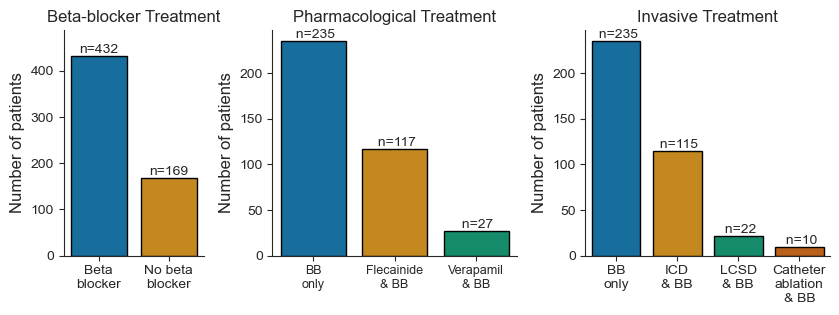

In [20]:
def plt_treatments_3():
    sns.set_style("ticks")

    curr_plot = get_config().s_figure_treatments.panels["figure_6_three_panels"]

    fig = plt.figure(
        figsize=curr_plot.fig_size)
    n_col = 8
    n_row = 1

    gs = GridSpec(n_row, n_col, figure=fig)

    plot_counts_df(
        len(set(df_cpvt_bb["individual_id"])),
        len(
            patient_ids - set(df_cpvt_bb["individual_id"])
        ),
        group_a="Beta\nblocker",
        group_b="No beta\nblocker",
        panel=curr_plot.panels["bb_vs_non_bb"],
        plt_figure=fig,
        subplot_spec=gs[0, :2]
    )
    plot_treatment_counts(
        treatment_nums,
        ["Beta blocker",
         # "Enalapril",
         "Flecainide",
         "Verapamil"],
        panel=curr_plot.panels[
            "pharmacological_treatment"],
        plt_figure=fig,
        subplot_spec=gs[0, 2:5]
    )

    plot_treatment_counts(
        treatment_nums,
        ["Beta blocker", "Catheter ablation",
         "Implantable cardioverter-defibrillator",
         "Left cardiac sympathetic denervation"],
        panel=curr_plot.panels["invasive_treatment"],
        plt_figure=fig,
        subplot_spec=gs[0, 5:]
    )
    fig.tight_layout()
    # plt.subplots_adjust(wspace=2)  # Add horizontal/vertical space
    save_current_plot("fig6_combined")
    plt.show()


plt_treatments_3()

In [21]:
# only variants with more than 10 patients
variants_by_bb_usage = pd.DataFrame(df_cpvt_bb.groupby(
    "p_hgvs_aa1"
)["individual_id"].count().sort_values(ascending=False))
# rename (number of bb patients to Total (number of patients on bb)
variants_by_bb_usage.columns = ["Total"]

# rename to p_hgvs_string
variants_by_bb_usage.index.name = "p_hgvs_string"

variants_by_bb_usage.to_csv(
    os.path.join(figures_dir / "all_variant_bb_list.csv")
)

variants_by_bb_usage.head()

,Total
p_hgvs_string,
G357S,94
R420Q,24
G2337V,21
R420W,17
M3978I,14


In [22]:
TOP_N_VARIANTS = 4
# only get the top (N) variants by usage + S2246L (another known variant but want to see if it's significant)
SELECTED_VARIANTS = [
    "S2246L",
    "C2277R"
]

variants_top_by_bb_usage = pd.concat(
    [
        variants_by_bb_usage.head(TOP_N_VARIANTS),
        variants_by_bb_usage[
            variants_by_bb_usage.index.isin(SELECTED_VARIANTS)]
    ],
)

variants_top_by_bb_usage

,Total
p_hgvs_string,
G357S,94
R420Q,24
G2337V,21
R420W,17
S2246L,9
C2277R,8


In [23]:
def create_fisher_table(
        # the input dataframe
        input_df: pd.DataFrame,
        # what treatment to look at
        treatment_name: str,
        # should be a df with index with the protein HGVS names using AA1 format
        totals_df: pd.DataFrame,
        *,
        other_treatment: str = "beta_blocker",
        treatment_col_name: str = None
):
    treat_and_col_name = f"{treatment_col_name if treatment_col_name else treatment_name}_and_{other_treatment}"

    fish_table = pd.DataFrame(
        input_df[
            (input_df[f"treatment_taken::{treatment_name}"] == 1)
            &
            (input_df["p_hgvs_aa1"].isin(totals_df.index))
            ].groupby("p_hgvs_aa1")["individual_id"].count(),
    )
    fish_table.columns = [treat_and_col_name]

    fish_table = fish_table.join(
        totals_df, how="outer"
    )
    fish_table.fillna(0, inplace=True)
    fish_table[f"{other_treatment}_only"] = (
            fish_table["Total"] - fish_table[
        treat_and_col_name]
    )

    # rename index
    fish_table.index.name = "p_hgvs_string"
    # rearrange columns
    fish_table = fish_table[[
        treat_and_col_name,
        f"{other_treatment}_only",
        "Total"
    ]]
    # set all to int
    fish_table = fish_table.astype(int)

    # remove index and sort by total
    fish_table.reset_index(inplace=True)
    fish_table = fish_table.sort_values(by="Total", ascending=False)

    return fish_table

In [24]:
# get the total number taking flecainide + beta blockers, beta blockers only, total in F + BB
for treatment, fish_name in {
    "Flecainide": "Flecainide",
    "Implantable cardioverter-defibrillator": "ICD",
}.items():
    treatment_and_bb = create_fisher_table(
        df_cpvt_bb,
        treatment,
        variants_top_by_bb_usage,
        treatment_col_name=fish_name
    )

    display(treatment_and_bb)

    treatment_and_bb.to_csv(
        os.path.join(figures_dir / f"cpvt_{fish_name}_bb.csv"),
        index=False
    )

,p_hgvs_string,Flecainide_and_beta_blocker,beta_blocker_only,Total
2,G357S,0,94,94
3,R420Q,2,22,24
1,G2337V,0,21,21
4,R420W,12,5,17
5,S2246L,3,6,9
0,C2277R,6,2,8


,p_hgvs_string,ICD_and_beta_blocker,beta_blocker_only,Total
2,G357S,1,93,94
3,R420Q,13,11,24
1,G2337V,1,20,21
4,R420W,5,12,17
5,S2246L,7,2,9
0,C2277R,1,7,8


## After Flecainide Reccomended by HRS

HRS/EHRA/APHRS Expert Consensus Statement on the Diagnosis and Management of Patients with Inherited Primary Arrhythmia Syndromes: Document endorsed by HRS, EHRA, and APHRS in May 2013 and by ACCF, AHA, PACES, and AEPC in June 2013. https://doi.org/10.1016/j.hrthm.2013.05.014

In [25]:
after_2013 = df_cpvt_bb[df_cpvt_bb["year"] >= 2013]
before_2013 = df_cpvt_bb[df_cpvt_bb["year"] < 2013]

variants_after_2013_bb_usage = pd.DataFrame(after_2013.groupby(
    "p_hgvs_aa1"
)["individual_id"].count().sort_values(ascending=False))

# rename (number of bb patients to Total (number of patients on bb)
variants_after_2013_bb_usage.columns = ["Total"]

# rename to p_hgvs_string
variants_after_2013_bb_usage.index.name = "p_hgvs_string"

variants_after_2013_bb_usage.to_csv(
    os.path.join(figures_dir / "all_variant_list_after_2013.csv")
)

variants_after_2013_bb_usage.head()

,Total
p_hgvs_string,
G357S,91
G2337V,21
R420Q,15
R420W,9
C2277R,8


In [26]:
variants_after_2013_by_bb_usage = pd.concat(
    [
        variants_after_2013_bb_usage.head(TOP_N_VARIANTS),
        variants_after_2013_bb_usage[
            variants_after_2013_bb_usage.index.isin(SELECTED_VARIANTS)]
    ],
)

variants_after_2013_by_bb_usage

,Total
p_hgvs_string,
G357S,91
G2337V,21
R420Q,15
R420W,9
C2277R,8
S2246L,4


In [27]:
f_and_bb_2013 = create_fisher_table(
    after_2013,
    "Flecainide",
    variants_after_2013_by_bb_usage,
)
f_and_bb_2013

,p_hgvs_string,Flecainide_and_beta_blocker,beta_blocker_only,Total
2,G357S,0,91,91
1,G2337V,0,21,21
3,R420Q,1,14,15
4,R420W,7,2,9
0,C2277R,6,2,8
5,S2246L,3,1,4


In [28]:
f_and_bb_2013.to_csv(
    os.path.join(figures_dir / f"flecainide_fisher_2013_and_after.csv"),
    index=False
)

In [29]:
# Compare proportions of F+B before and after 2013
data_cmp = df_cpvt_bb.drop_duplicates("individual_id").copy()
data_cmp["before_2013"] = data_cmp["year"] < 2013
data_cmp = data_cmp.groupby("before_2013").agg(
    {
        "treatment_taken::Flecainide": "sum",
        "treatment_taken::Beta blocker": "sum"
    }
).rename(
    columns={
        "treatment_taken::Flecainide": "Flecainide_and_beta_blocker",
        "treatment_taken::Beta blocker": "Total"
    }
)
data_cmp["Beta_blocker_only"] = data_cmp["Total"] - data_cmp[
    "Flecainide_and_beta_blocker"]

data_cmp = data_cmp[
    ["Flecainide_and_beta_blocker", "Beta_blocker_only", "Total"]]

# rename index
data_cmp.index = ["2013 and after", "Before 2013"]
data_cmp.index.name = "Group"

data_cmp.head()

,Flecainide_and_beta_blocker,Beta_blocker_only,Total
Group,,,
2013 and after,80.0,239.0,319.0
Before 2013,37.0,76.0,113.0


In [30]:
# get number of publicatrions
data_cmp_pub = df_cpvt_bb.copy()
data_cmp_pub["before_2013"] = data_cmp_pub["year"] < 2013
data_cmp_pub = data_cmp_pub[data_cmp_pub["treatment_taken::Flecainide"] == True]

data_cmp_pub = data_cmp_pub.groupby("before_2013").agg(
    {
        "publication_id": "nunique",
        "individual_id": "nunique"
    }
).rename(
    columns={
        "publication_id": "num_publications",
        "individual_id": "num_individuals"
    }
)
data_cmp_pub

,num_publications,num_individuals
before_2013,,
False,36,80
True,6,37


## Plot Percentages

,p_hgvs_string,Flecainide_and_beta_blocker,beta_blocker_only,Total,Flecainide_and_beta_blocker_pct,total_pct
2,G357S,0,91,91,0.000000,100
1,G2337V,0,21,21,0.000000,100
3,R420Q,1,14,15,6.666667,100
4,R420W,7,2,9,77.777778,100
0,C2277R,6,2,8,75.000000,100
5,S2246L,3,1,4,75.000000,100


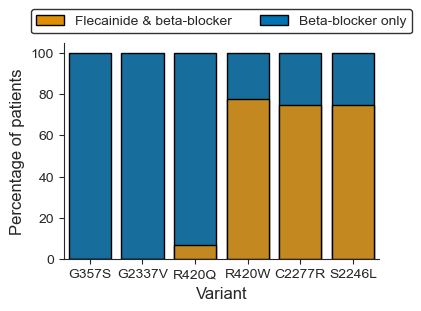

In [31]:
import matplotlib.patches as mpatches

sns.set_style("ticks")


def plot_bb_percentages(
        df_fish: pd.DataFrame,
        panel: FigureParams,
        group_a: str,
        legend_a: str,
        legend_b: str,
        plt_name: str,
        plt_order: list[str] = None,
):
    plt.figure(
        figsize=panel.fig_size
    )

    df_fish_pct = df_fish.copy()
    df_fish_pct[f"{group_a}_pct"] = (
            df_fish[group_a] / df_fish["Total"] * 100
    )
    df_fish_pct["total_pct"] = 100

    display(df_fish_pct)

    color1 = sns.color_palette(get_config().figure_palette.cat_palette)[0]
    color2 = sns.color_palette(get_config().figure_palette.cat_palette)[1]

    plt_order = plt_order if plt_order else df_fish_pct["p_hgvs_string"]

    sns.barplot(
        x="p_hgvs_string",
        y="total_pct",
        data=df_fish_pct,
        color=color1,
        edgecolor="black",
        order=plt_order
    )
    sns.barplot(
        x="p_hgvs_string",
        y=f"{group_a}_pct",
        data=df_fish_pct,
        color=color2,
        edgecolor="black",
        order=plt_order
    )

    top_bar = mpatches.Patch(
        facecolor=color2,
        label=legend_a,
        edgecolor="black"
    )
    bottom_bar = mpatches.Patch(
        facecolor=color1,
        label=legend_b,
        edgecolor="black"
    )

    plt.legend(
        handles=[top_bar, bottom_bar],
        loc="center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=2,
        edgecolor="black"
    )

    set_figure_size(
        panel
    )
    save_current_plot(plt_name)

    plt.show()


plot_order = f_and_bb_2013["p_hgvs_string"].tolist()

plot_bb_percentages(
    f_and_bb_2013,
    get_config().treatment_pcts.panels["flecainide_pct"],
    "Flecainide_and_beta_blocker",
    "Flecainide & beta-blocker",
    "Beta-blocker only",
    "flecainide_bb_percentages",
    plt_order=plot_order
)

In [32]:
icd_fisher = create_fisher_table(
    df_cpvt_bb,
    "Implantable cardioverter-defibrillator",
    variants_top_by_bb_usage,
    treatment_col_name="ICD"
)

icd_fisher.head()

,p_hgvs_string,ICD_and_beta_blocker,beta_blocker_only,Total
2,G357S,1,93,94
3,R420Q,13,11,24
1,G2337V,1,20,21
4,R420W,5,12,17
5,S2246L,7,2,9


,p_hgvs_string,ICD_and_beta_blocker,beta_blocker_only,Total,ICD_and_beta_blocker_pct,total_pct
2,G357S,1,93,94,1.063830,100
3,R420Q,13,11,24,54.166667,100
1,G2337V,1,20,21,4.761905,100
4,R420W,5,12,17,29.411765,100
5,S2246L,7,2,9,77.777778,100
0,C2277R,1,7,8,12.500000,100


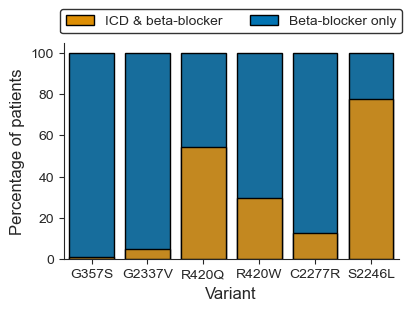

In [33]:
plot_bb_percentages(
    icd_fisher,
    get_config().treatment_pcts.panels["icd_pct"],
    "ICD_and_beta_blocker",
    "ICD & beta-blocker",
    "Beta-blocker only",
    "icd_bb_percentages",
    plt_order=plot_order
)

## Any Pharm + Any Invasive vs BB Only

In [34]:
df_cpvt_bb_vs_other = df_cpvt_bb
df_cpvt_bb_vs_other = df_cpvt_bb_vs_other[[
                                              "individual_id",
                                              "year",
                                              "p_hgvs_aa1",
                                              "treatment_taken::Beta blocker",
                                          ] + pharm_treat + invasive_treat].copy()

df_cpvt_bb_vs_other = df_cpvt_bb_vs_other.drop_duplicates(
    "individual_id", keep="first")

df_cpvt_bb_vs_other["treatment_taken::any_pharm"] = df_cpvt_bb_vs_other[
                                                        pharm_treat].fillna(
    0).sum(axis=1) > 0

df_cpvt_bb_vs_other["treatment_taken::any_invasive"] = df_cpvt_bb_vs_other[
                                                           invasive_treat].fillna(
    0).sum(axis=1) > 0

df_cpvt_bb_vs_other["treatment_taken::any_additional"] = (
        df_cpvt_bb_vs_other["treatment_taken::any_pharm"] |
        df_cpvt_bb_vs_other["treatment_taken::any_invasive"]
)

any_pharm = df_cpvt_bb_vs_other["treatment_taken::any_pharm"].sum()
any_invasive = df_cpvt_bb_vs_other["treatment_taken::any_invasive"].sum()
any_other = df_cpvt_bb_vs_other["treatment_taken::any_additional"].sum()

print(f"Number of patients on any pharmacological treatment: {any_pharm}")
print(f"Number of patients on any invasive treatment: {any_invasive}")
print(f"Number of patients on any additional treatment: {any_other}")

df_cpvt_bb_vs_other.head()

Number of patients on any pharmacological treatment: 129
Number of patients on any invasive treatment: 129
Number of patients on any additional treatment: 197


,individual_id,year,p_hgvs_aa1,treatment_taken::Beta blocker,treatment_taken::Flecainide,treatment_taken::Verapamil,treatment_taken::Catheter ablation,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::any_pharm,treatment_taken::any_invasive,treatment_taken::any_additional
1,2,2011,Y4962C,1.0,1.0,0.0,0.0,0.0,0.0,True,False,True
3,4,2013,Y4725C,1.0,0.0,0.0,0.0,0.0,0.0,False,False,False
11,12,2016,Y4080C,1.0,1.0,0.0,0.0,1.0,1.0,True,True,True
26,27,2012,W4949R,1.0,0.0,NaN,0.0,NaN,0.0,False,False,False
27,28,2009,W4645R,1.0,0.0,0.0,0.0,0.0,0.0,False,False,False


In [35]:
any_pharm_fish = create_fisher_table(
    df_cpvt_bb_vs_other[
        df_cpvt_bb_vs_other["year"] >= 2013
        ],
    "any_pharm",
    variants_after_2013_by_bb_usage,
    treatment_col_name="any_pharm"
)

any_pharm_fish

,p_hgvs_string,any_pharm_and_beta_blocker,beta_blocker_only,Total
2,G357S,0,91,91
1,G2337V,0,21,21
3,R420Q,1,14,15
4,R420W,7,2,9
0,C2277R,6,2,8
5,S2246L,3,1,4


In [36]:
any_invasive_fish = create_fisher_table(
    df_cpvt_bb_vs_other,
    "any_invasive",
    variants_top_by_bb_usage,
    treatment_col_name="any_invasive"
)

any_invasive_fish

,p_hgvs_string,any_invasive_and_beta_blocker,beta_blocker_only,Total
2,G357S,1,93,94
3,R420Q,14,10,24
1,G2337V,1,20,21
4,R420W,5,12,17
5,S2246L,7,2,9
0,C2277R,1,7,8


In [37]:
any_add_fish = create_fisher_table(
    df_cpvt_bb_vs_other[
        df_cpvt_bb_vs_other["year"] >= 2013
        ],
    "any_additional",
    variants_after_2013_by_bb_usage,
    treatment_col_name="any_additional"
)

any_add_fish

,p_hgvs_string,any_additional_and_beta_blocker,beta_blocker_only,Total
2,G357S,0,91,91
1,G2337V,1,20,21
3,R420Q,8,7,15
4,R420W,8,1,9
0,C2277R,6,2,8
5,S2246L,3,1,4


In [38]:
with pd.ExcelWriter(
        figures_dir / "any_treat_fish.xlsx",
        mode="w"
) as writer:
    any_pharm_fish.to_excel(writer, index=False,
                            sheet_name="any_pharm")
    any_invasive_fish.to_excel(writer, index=False, sheet_name="any_invasive")

    any_add_fish.to_excel(writer, index=False,
                          sheet_name="any_additional")

,p_hgvs_string,any_pharm_and_beta_blocker,beta_blocker_only,Total,any_pharm_and_beta_blocker_pct,total_pct
2,G357S,0,91,91,0.000000,100
1,G2337V,0,21,21,0.000000,100
3,R420Q,1,14,15,6.666667,100
4,R420W,7,2,9,77.777778,100
0,C2277R,6,2,8,75.000000,100
5,S2246L,3,1,4,75.000000,100


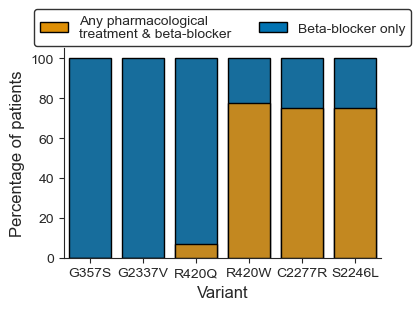

In [39]:
plot_bb_percentages(
    any_pharm_fish,
    get_config().treatment_pcts.panels["flecainide_pct"],
    "any_pharm_and_beta_blocker",
    "Any pharmacological\ntreatment & beta-blocker",
    "Beta-blocker only",
    "any_pharm_bb_percentages",
    plt_order=plot_order
)

,p_hgvs_string,any_invasive_and_beta_blocker,beta_blocker_only,Total,any_invasive_and_beta_blocker_pct,total_pct
2,G357S,1,93,94,1.063830,100
3,R420Q,14,10,24,58.333333,100
1,G2337V,1,20,21,4.761905,100
4,R420W,5,12,17,29.411765,100
5,S2246L,7,2,9,77.777778,100
0,C2277R,1,7,8,12.500000,100


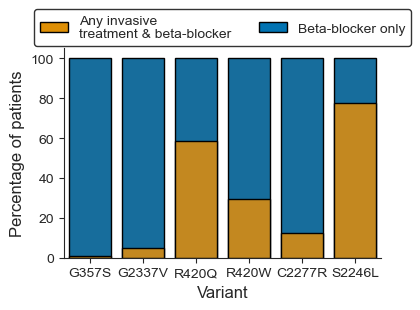

In [40]:
plot_bb_percentages(
    any_invasive_fish,
    get_config().treatment_pcts.panels["icd_pct"],
    "any_invasive_and_beta_blocker",
    "Any invasive\ntreatment & beta-blocker",
    "Beta-blocker only",
    "any_invasive_bb_percentages",
    plt_order=plot_order
)

,p_hgvs_string,any_additional_and_beta_blocker,beta_blocker_only,Total,any_additional_and_beta_blocker_pct,total_pct
2,G357S,0,91,91,0.000000,100
1,G2337V,1,20,21,4.761905,100
3,R420Q,8,7,15,53.333333,100
4,R420W,8,1,9,88.888889,100
0,C2277R,6,2,8,75.000000,100
5,S2246L,3,1,4,75.000000,100


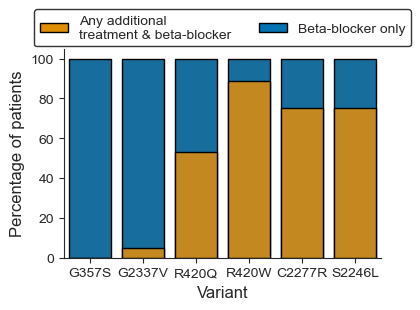

In [41]:
plot_bb_percentages(
    any_add_fish,
    get_config().treatment_pcts.panels["icd_pct"],
    "any_additional_and_beta_blocker",
    "Any additional\ntreatment & beta-blocker",
    "Beta-blocker only",
    "any_additional_bb_percentages",
    plt_order=plot_order
)